In [676]:
import importlib

import down_data
importlib.reload(down_data)

import virtual_market
importlib.reload(virtual_market)

import pandas as pd
import numpy as np
import time

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.options.display.max_colwidth = 100
%matplotlib inline

In [2]:
def extract_coin_columns(df, coin_name):
    return df.loc[:, df.columns.str.endswith('_' + coin_name)]

def plot_coin(df):
    coin_name = df.columns[0].split('_')[1]
    
    ax = df.loc[:, df.columns.str.startswith('open')].plot(figsize=(20,10), title=coin_name, style='.-')
    ax = df.loc[:, df.columns.str.startswith('close')].plot(figsize=(20,10), ax=ax, style='.-')
    ax = df.loc[:, df.columns.str.startswith('high')].plot(figsize=(20,10), ax=ax, style='.-')
    df.loc[:, df.columns.str.startswith('low')].plot(figsize=(20,10), ax=ax, style='.-')

In [602]:
coins_list_btc_small = ['SYS','BCN','DGB']
coins_list_btc = ['SYS','BCN','DGB','LBC','NOTE','PASC','NAUT','SC','NEOS','ETH','ZEC','MAID','XRP',
                  'BTS','XEM','SBD','STRAT','LTC','AMP','BCY','ETC','ARDR','POT','NXT','BELA','XBC',
                  'BTCD','XMR','NXC','XCP','DCR','BLK','RIC','STEEM','NMC','PINK','OMNI','SJCX','NAV']
coins_list_btc_bcn = ['BCN']

In [4]:
down = down_data.Downloader()

In [704]:
df_big = pd.DataFrame()
df_small = pd.DataFrame
coin_btc_previous = ''
limit = 1440
aggregate = 2
counter = 0
t_horiz = 'minute'

for coin_btc in coins_list_btc_bcn:
    counter += 1
    print(coin_btc, counter, len(coins_list_btc))
    histo = down.get_histo_json(coin_btc, 'BTC', limit=limit, aggregate=aggregate, t_horiz=t_horiz)
    if len(df_big) == 0:
        df_big = pd.DataFrame(histo['Data']).add_suffix('_' + coin_btc).rename(columns={'time_'+coin_btc:'time'})
    else:
        df_small = pd.DataFrame(histo['Data']).add_suffix('_' + coin_btc).rename(columns={'time_'+coin_btc:'time'})
        df_big = pd.merge(df_big, df_small, on='time')
    time.sleep(0.5)
df_big = df_big.set_index('time')
df_big.index = pd.to_datetime(df_big.index, unit='s')

BCN 1 39
get_histominute request: https://min-api.cryptocompare.com/data/histominute?&fsym=BCN&tsym=BTC&limit=1440&aggregate=2&e=Poloniex


In [705]:
df_bcn = extract_coin_columns(df=df_big, coin_name='BCN')

In [706]:
df_bcn.head(2)

,close_BCN,high_BCN,low_BCN,open_BCN,volumefrom_BCN,volumeto_BCN
time,,,,,,
2017-09-14 02:50:00,4.000000e-07,4.000000e-07,4.000000e-07,4.000000e-07,0.00,0.00000
2017-09-14 02:52:00,3.900000e-07,4.000000e-07,3.900000e-07,4.000000e-07,215856.37,0.08418


In [707]:
df_bcn.tail(2)

,close_BCN,high_BCN,low_BCN,open_BCN,volumefrom_BCN,volumeto_BCN
time,,,,,,
2017-09-15 12:08:00,3.100000e-07,3.200000e-07,3.100000e-07,3.200000e-07,921281.13,0.287900
2017-09-15 12:10:00,3.200000e-07,3.200000e-07,3.100000e-07,3.100000e-07,15610.90,0.004995


In [708]:
#ax = df_bcn.open_BCN.plot()
#i = 5
#df_bcn.open_BCN.shift(-int(i/2)).rolling(window=i).mean().plot(figsize=(20,10), ax=ax)

In [709]:
df_bcn['open_BCN_diff'] = 100*df_bcn.open_BCN.diff()/df_bcn.open_BCN    #df_bcn.open_BCN.shift(1)/df_bcn.open_BCN
df_bcn.open_BCN_diff = df_bcn.open_BCN_diff.fillna(value=0)

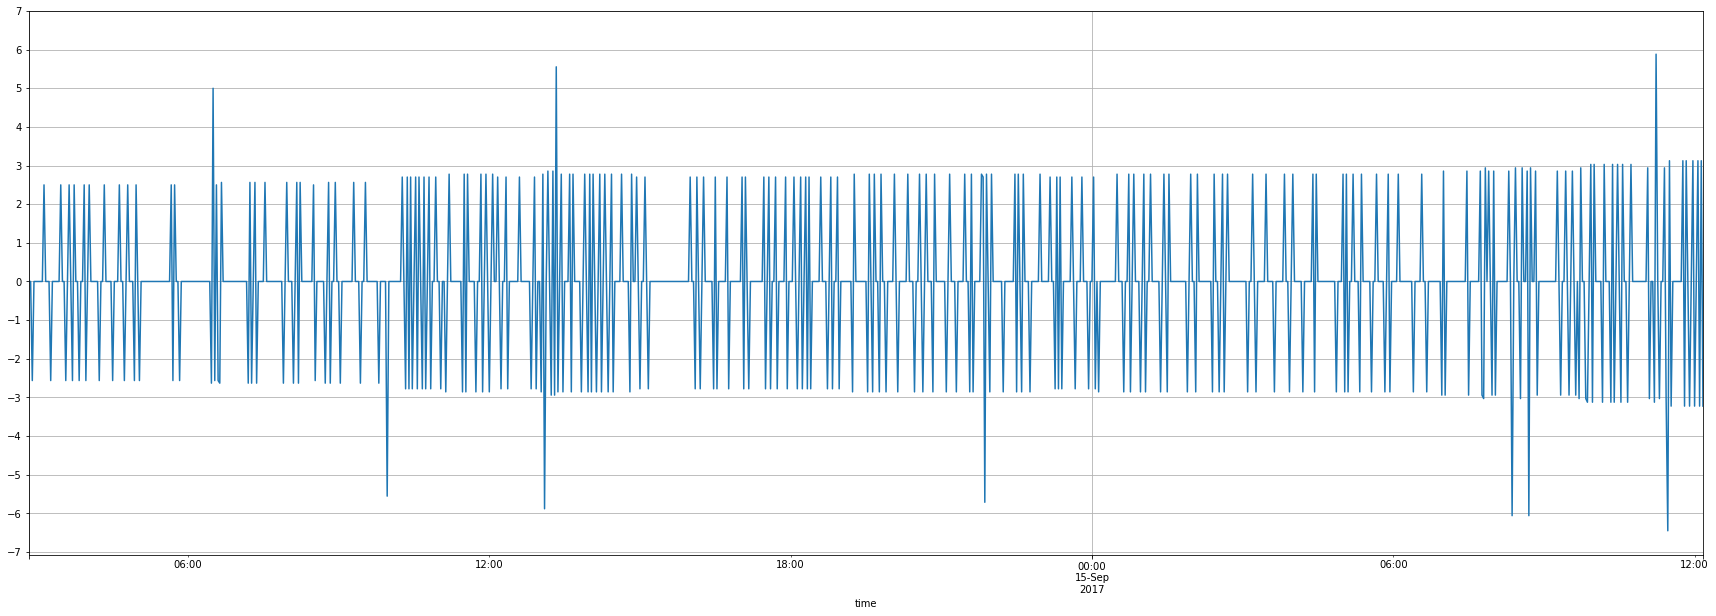

In [710]:
df_bcn.open_BCN_diff.plot(figsize=(30,10), yticks=np.round(np.arange(min(df_bcn.open_BCN_diff)-1, max(df_bcn.open_BCN_diff)+1, 1)), grid=True)

In [711]:
import virtual_market
importlib.reload(virtual_market)

<module 'virtual_market' from 'D:\\work\\cr\\Crypto_history_funn\\virtual_market.py'>

In [714]:
buy = pd.DataFrame(df_bcn.open_BCN_diff[df_bcn.open_BCN_diff < -2])
buy['Type'] = 'buy'
sell = pd.DataFrame(df_bcn.open_BCN_diff[df_bcn.open_BCN_diff > 2])
sell['Type'] = 'sell'
buysell = buy.append(sell).sort_index()

print(buysell[buysell.Type == 'sell'].shape[0])
print(buysell[buysell.Type == 'buy'].shape[0])

buysell['Value'] = df_bcn.open_BCN[buysell.index]

market = virtual_market.Market(0, 1000, max_opens=100)
market.print_have()
amount = 900

buysell_dont = 0
buysell_done = 0

for index, row in buysell.iterrows():
    #print(index, row['Type'], row['open_BCN_diff'], row['Value'])
    if row['Type'] == 'sell':
        res = market.sell_bcn(amount=amount, price_btc=row['Value'])
        if res == '':
            buysell_dont += 1
        else:
            buysell_done += 1
    if row['Type'] == 'buy':
        res = market.buy_bcn(amount=amount, price_btc=row['Value'])
        if res == '':
            buysell_dont += 1
        else:
            buysell_done += 1

print()
market.print_have()
print()
print('buysell_dont:', buysell_dont)
print('buysell_done:', buysell_done)

163
169
have_bcn = 1000
have_btc = 0 [aprox.  0 $ pseudo]
Total have aprox.: 1.5999999999999999 $ pseudo

have_bcn = 4382.650000000004
have_btc = 0.00011200950000000152 [aprox.  0.44803800000000604 $ pseudo]
Total have aprox.: 7.460278000000012 $ pseudo

buysell_dont: 14
buysell_done: 318


In [698]:
market = virtual_market.Market(0.01, 1000)

In [699]:
market.print_have()

have_bcn = 1000
have_btc = 0.01 [aprox.  40.0 $ points]
Total have aprox.: 41.6 $ points


In [700]:
market.buy_bcn(5000, 0.0000004)

'a'

In [701]:
market.sell_bcn(5000, 0.0000004)

'a'